# Data and Web Mining
## Kaggle ft Child Institute: problematic internet use 
alleneremo e metteremo a confronto due modelli. uno ad albero e uno basato su rete neurale.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from data_cleaning_module import prepare_data, augment_data, correlation_matrix1, correlation_matrix2, feature_importance_and_mutual_info, backward_elimination
from model0_baseline_module import run_baseline
#from model1_XGBoost_module import tune_and_train_xgboost, test_xgboost
#from model2_ann_module import run_nn, prepare_X, impute_missing_values, rf_cascade, tune_hyperparameters, test_ann_pipeline
SEED = 42 # global random seed for reproducibility

# Preparazione dati
Le prime cosa da fare a partire dai dati grezzi sono: split tra train/validation/test, trasformazione delle variabili categoriche in variabili numeriche e eliminazione delle features con troppi NaN, non predittive o ridondanti. Nel train abbiamo eliminato tutte le colonne con una percentuale di missing values > 50%.
Abbiamo deciso di adottare un approccio ordinale per mappare le stagioni in numeri: winter:0, spring:1, summer:2, fall:3, NaN:NaN.
Dopodiché abbiamo fatto la matrice di correlazione tra tutte le colonne rimanenti, eliminando le features ridondanti (correlazione > 0.9).

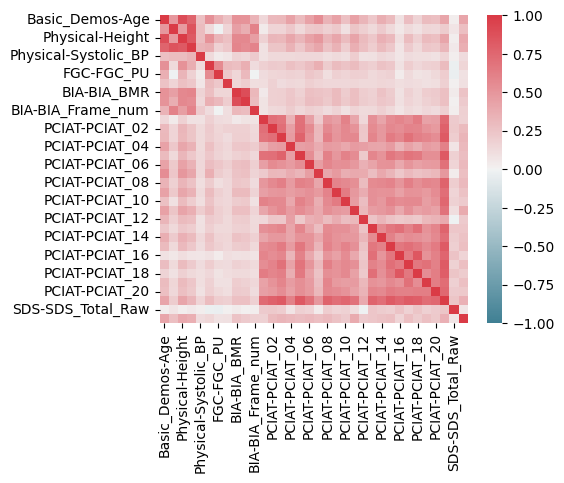

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data("../data/train.csv", SEED)
X_train_filtered = correlation_matrix1(X_train, y_train)

Per scremare ulteriormente le features (per avere maggior interpretabilità e minore complessità computazionale), abbiamo allenato una random forest in cross validation, per valutare la features importance. Abbiamo anche dato un'occhiata all'analisi statistica "mutual information", che non dipende dal modello, ma misura "quanto sapere la feature aiuta a prevedere la classe". Messa in grafico col NaN ratio, dà anch'essa una buona misura di cosa sia significativo o meno, per confrontarlo coi risultati ottenuti dalla feature importance appena calcolata.

c:\Users\Dav\Uni_Lavoro\data-web-mining-project\src\data_cleaning_module.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


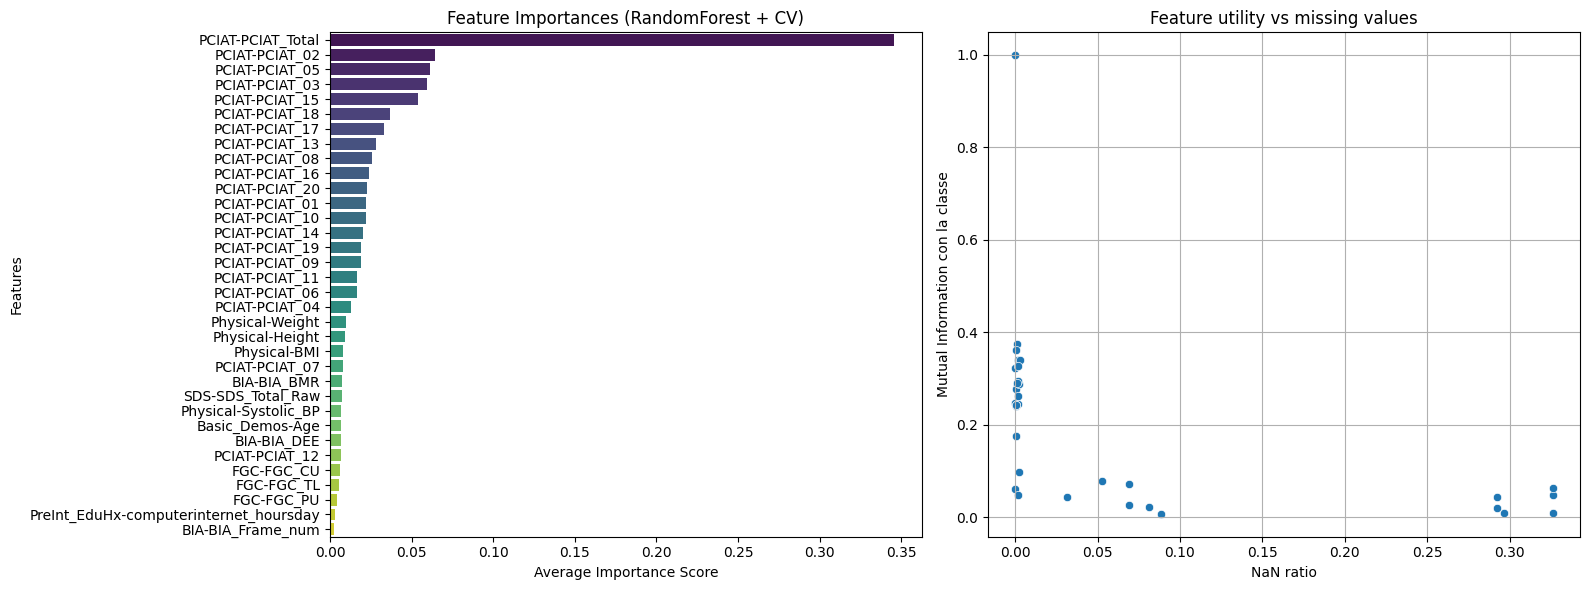

In [3]:
feat_imp_cv, feat_imp_cv_sorted = feature_importance_and_mutual_info(X_train_filtered, y_train, SEED)

Dall’analisi della feature importance e della mutual information emergono alcune evidenze. La variabile più predittiva per l’etichetta Sii è PCIAT_Total, seguita da alcune specifiche domande (02, 05, 03, 15, 17). Le due analisi concordano: le feature più rilevanti coincidono, mentre quelle con un alto numero di valori mancanti o con bassa MI risultano poco utili e possono essere eliminate, ad esempio tramite una random forest.
Tuttavia, le variabili PCIAT introducono un problema di data leakage, perché sono fortemente correlate o addirittura derivate direttamente dal target, quindi non sarebbero disponibili in scenari reali. Per questo motivo è necessario escluderle dal training del modello. Allo stesso tempo, proprio per la loro forte correlazione, esse possono essere sfruttate in un secondo momento per stimare i valori mancanti di Sii e arricchire così il dataset.

### Proxy Model
Procediamo quindi con la creazione del modello di imputazione. Dovremo quindi rifare i passaggi già eseguiti, in quanto il primo passo fatto è stato eliminare le righe con sii ignoto.
1. a Partire dal dataset originale, ripetiamo i passi base di preparazione dati:
   1. separiamo train/test
   2. A partire da X_train creiamo due df distinti, di cui uno contiene le righe del training set dove sii è noto, uno dove è NaN
   3. uso le PCIAT come features e sii come target per allenare una semplice ma efficace random forest, che poi uso sul df con sii NaN.
2. A questo punto, imputiamo i valori di sii mancanti.
3. Eliminiamo quindi direttamente le colonne PCIAT, ripetendo la feature selection come fatta prima, senza che queste colonne siano coinvolte.

In [4]:
X_train_final, y_train_final, X_test, y_test = augment_data()

Righe di X_training con 'sii' noto: 2193
Righe di X_training da imputare: 975
Dataset salvati in formato CSV nella cartella 'data/'.


* `X_train_final`: contiene il set di training, totale: senza le colonne PCIAT e aumentato con le righe che inizialmente avevano sii nullo
* `y_train_final`: target del training, con tutte le righe, anche quelle imputate
* `X_test`, `y_test`: set di test, intoccati, con dati ancora grezzi

A questo punto, ci sono quasi 1000 righe in più su cui allenare i modelli.
Procediamo a rifare i passi eseguiti in precedenza riguardanti pulizia dei dati e feature importance. (cambiare le stagioni, matrice di correlazione, feature importance, nan ratio)

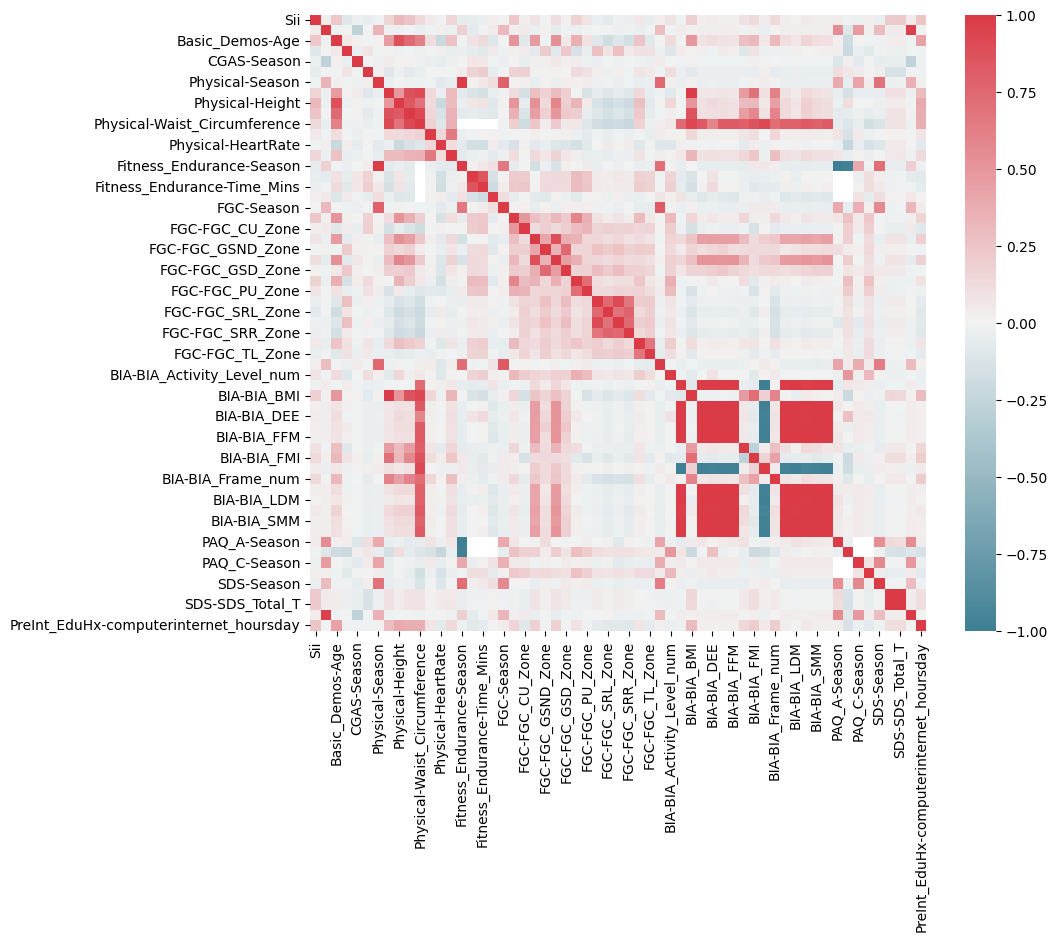

In [5]:
correlation_matrix2(X_train_final, y_train_final)

c:\Users\Dav\Uni_Lavoro\data-web-mining-project\src\data_cleaning_module.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


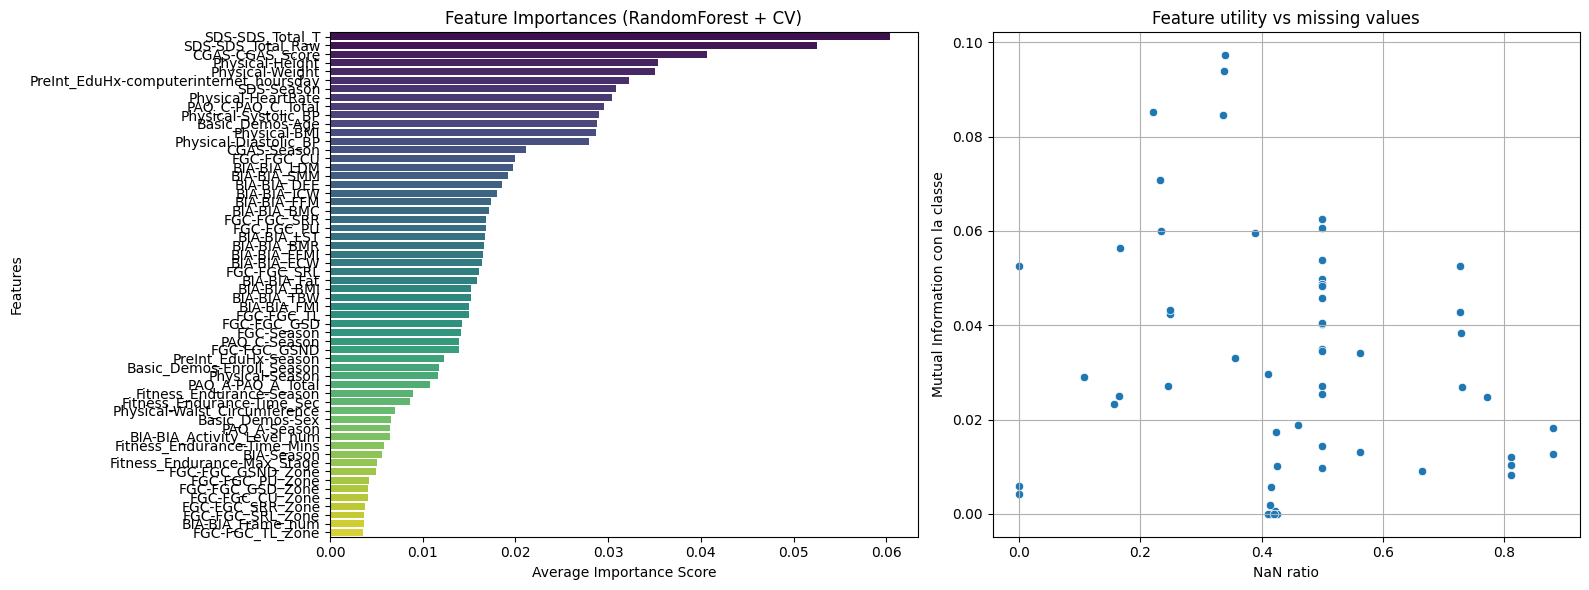

In [6]:
feat_imp, feat_imp_sorted = feature_importance_and_mutual_info(X_train_final, y_train_final, SEED)

l'importance score è in generale molto più basso e decisamente meno sbilanciato di prima. Le features con NaN ratio alto non sono quelle con importance in assoluto minore, ma sono comunque nella bassa classifica, come atteso. Ugualmente alta mutual information corrisponde ad alta importance.

### Feature subset selection by elimination

Abbiamo applicato una backward feature selection utilizzando come modello una Random Forest. Siamo partiti dal set completo di variabili e abbiamo rimosso iterativamente quelle con minor feature importance, valutando a ogni passo le performance sul validation set. Questo approccio ha il vantaggio di gestire bene le feature correlate: infatti, la Random Forest tende a dividere l’importanza tra variabili simili, ma con la rimozione progressiva una di esse può rivelarsi molto più rilevante, compensando così la penalizzazione dovuta alla ridondanza.

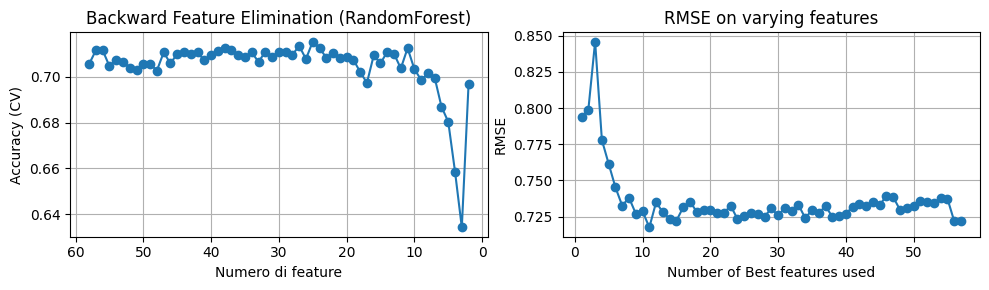

Top 11 features (RandomForest CV):
1. SDS-SDS_Total_T
2. SDS-SDS_Total_Raw
3. CGAS-CGAS_Score
4. Physical-Height
5. Physical-Weight
6. PreInt_EduHx-computerinternet_hoursday
7. SDS-Season
8. Physical-HeartRate
9. PAQ_C-PAQ_C_Total
10. Physical-Systolic_BP
11. Basic_Demos-Age
'data/X_train_final.csv' sovrascritto coi nuovi dati.


In [7]:
X_train_final, features_list = backward_elimination(X_train_final, y_train_final, feat_imp, feat_imp_sorted, SEED)

Da questi due grafici si evince che è possibile eliminare ripetutamente le features senza perdite in termini di accuracy: è chiaro come avere una decina di features sia tanto significativo quanto averle tutte, la perdita di accuracy è totalmente giustificata dalla semplificazione del modello. nel range 20-10 c'è una diminuzione leggermente più marcata, con maggiore varibilità, ma forse ugualmente accettabile. Da 11 in giù le performance calano sensibilmente.

Abbiamo scelto di tenerne quindi 11. proseguiamo quindi con:
1. Mostrare le feature ordinate per importanza
2. Selezionare le prime 11 e droppare dal dataset le features non utilizzate

# roba da eliminaere
questa cella di codice in realtà è l'unione dei moduli, così da poterli modificare direttamente qui, in produzione va tolta

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from data_cleaning_module import season_map
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, recall_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import keras_tuner as kt
from tensorflow.keras.models import load_model




def tune_and_train_xgboost(X_train, y_train, X_val, y_val, num_classes, n_trials=50):

    class_counts = np.bincount(y_train)
    total = len(y_train)
    weights = {i: total / (len(class_counts) * c) for i, c in enumerate(class_counts)}
    sample_weights = np.array([weights[label] for label in y_train])

    def objective(trial):
        params = {
            'objective': 'multi:softprob',
            'num_class': num_classes,
            'tree_method': 'hist',
            'eval_metric': ['mlogloss', 'merror'],
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        }

        model = XGBClassifier(**params, n_estimators=1000, verbosity=0, early_stopping_rounds=50)
        model.fit(X_train, y_train, sample_weight=sample_weights,
                  eval_set=[(X_val, y_val)],verbose=False)
        y_pred_val = model.predict(X_val)
        return f1_score(y_val, y_pred_val, average='weighted')
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    print("Best hyperparameters:", study.best_params)

    best_params = study.best_params
    best_params.update({
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'tree_method': 'auto',
        'eval_metric': ['mlogloss', 'merror']
    })

    model_final = XGBClassifier(**best_params, n_estimators=1000, verbosity=0,early_stopping_rounds=50)
    model_final.fit(X_train, y_train, sample_weight=sample_weights,
                    eval_set=[(X_train, y_train),(X_val, y_val)],verbose=False)
    
    model_final = XGBClassifier(**best_params, n_estimators=1000, verbosity=0,early_stopping_rounds=50)
    model_final.fit(X_train, y_train, sample_weight=sample_weights,
                    eval_set=[(X_train, y_train),(X_val, y_val)],verbose=False)

    evals_result = model_final.evals_result()

    epochs = range(len(evals_result['validation_0']['mlogloss']))
    fig, axes = plt.subplots(1, 3, figsize=(20,5))

    axes[0].plot(epochs, evals_result['validation_0']['mlogloss'], label='Train Loss')
    axes[0].plot(epochs, evals_result['validation_1']['mlogloss'], label='Validation Loss')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Log Loss")
    axes[0].set_title("Training vs Validation Loss")
    axes[0].legend()
    axes[0].grid(True)

    train_acc = [1 - x for x in evals_result['validation_0']['merror']]
    val_acc = [1 - x for x in evals_result['validation_1']['merror']]
    axes[1].plot(epochs, train_acc, label='Train Accuracy')
    axes[1].plot(epochs, val_acc, label='Validation Accuracy')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Training vs Validation Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    y_pred_val = model_final.predict(X_val)
    cm_val = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[2])
    axes[2].set_title("Confusion Matrix - Validation")
    axes[2].set_xlabel("Predicted")
    axes[2].set_ylabel("True")
    

    print("=== Validation Set ===")
    print("Accuracy:", accuracy_score(y_val, y_pred_val))
    print("Weighted F1:", f1_score(y_val, y_pred_val, average='weighted'))

    # Classification report come tabella grafica
    report_dict = classification_report(y_val, y_pred_val, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose().round(2)

    plt.figure(figsize=(10, report_df.shape[0]*0.6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="Blues", cbar=False, fmt=".2f")
    plt.title("Classification Report - Validation Set")
    plt.ylabel("Classes")
    plt.xlabel("Metrics")

    plt.tight_layout()
    plt.show()

    return model_final, study

def test_xgboost(model, X_test, y_test, scaler, Imputer, classes=["0","1","2","3"], SEED=42):

    X_test = season_map(X_test)
    X_test_imputed = Imputer.fit_transform(X_test)
    X_test_scaled = scaler.transform(X_test_imputed)

    y_pred = model.predict(X_test_scaled)
    print("=== XGBoost - Classification Report (Test) ===")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("XGBoost Confusion Matrix (Test)")
    plt.show()


def prepare_X (X_tr, X_val, y_tr, y_val, SEED):
    tf.random.set_seed(SEED)

    scaler = StandardScaler()

    # uso il train per calcolare media e deviazione standard, e standardizzo tutto (train, val, test)

    X_tr_filled = X_tr.fillna(-9999).copy() 
    X_val_filled = X_val.fillna(-9999).copy()  

    X_tr_scaled = scaler.fit_transform(X_tr_filled)    
    X_val_scaled = scaler.transform(X_val_filled)

    classes = np.unique(y_tr) # array delle classi presenti nel training set
    num_classes = len(classes)

    auto_weights = compute_class_weight(class_weight='balanced',
                                        classes=classes,
                                        y=y_tr)
    class_weights = {cls: w for cls, w in zip(classes, auto_weights)}

    return X_tr_scaled, X_val_scaled, class_weights, scaler

def build_model(n_features,
                n_classes = 4,
                hidden_units=[64,32],
                activation='relu',
                lr=1e-3,
                dropout=0.0,
                l2_reg=0.0,
                loss_case_binary = "binary_crossentropy",
                loss_case_multiclass = "sparse_categorical_crossentropy",
                loss_case_regression="mse",
                metrics=['accuracy', ]):
    
    # Definisce il layer di input, dimensione = numero di feature
    inputs = layers.Input(shape=(n_features,))
    
    x = inputs    # Variabile temporanea per "costruire" i layer successivi
    for units in hidden_units:
        
        x = layers.Dense(units, # denso -> fully-connected
                         activation = activation,
                         kernel_regularizer = keras.regularizers.l2(l2_reg))(x) # l2_reg
        if dropout and dropout > 0.0: 
            x = layers.Dropout(dropout)(x) # applico il dropout
    if n_classes == None:
        out = layers.Dense(1, activation='linear')(x)
        loss = loss_case_regression
    elif n_classes <= 2: # classificazione binaria
        out = layers.Dense(1, activation='sigmoid')(x)
        loss = loss_case_binary
    else: # classificazione multiclasse
        out = layers.Dense(n_classes, activation='softmax')(x)
        loss = loss_case_multiclass

    model = keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=metrics)
    
    return model


def run_nn (X, Xv, y, yv, _num_features = 11, _num_classes = 4, hidden_units=[64,32], activation='relu', lr=1e-4, dropout=0, l2_reg=0, patience_early_stopping = 50, patience_reduce_lr = 6, factor = 0.5, min_lr=1e-6, epochs = 500, batch_size=32, loss_case_binary = "binary_crossentropy", loss_case_multiclass = "sparse_categorical_crossentropy", loss_case_regression="mse", metrics=['accuracy', ], weights = None, classes = ["0","1","2","3"]):
    """"
    * _num_features: int, numero di feature in input
    * _num_classes: int, numero di classi in output (None per regressione)
    * hidden_units: lista di interi, numero di neuroni per layer nascosti
    * activation: stringa, funzione di attivazione da usare nei layer nascosti
    * lr: float, learning rate iniziale
    * dropout: float, percentuale di dropout da applicare
    * l2_reg: float, coefficiente di regolarizzazione L2
    * patience_early_stopping: int, numero di epoche senza miglioramento prima di fermare l'allenamento
    * patience_reduce_lr: int, numero di epoche senza miglioramento prima di ridurre il learning rate
    * factor: float, fattore di riduzione del learning rate se la loss di validazione non migliora
    * min_lr: float, learning rate minimo a cui ridurre
    * epochs: int, numero massimo di epoche per l'allenamento
    * batch_size: int, numero di campioni per batch
    * loss_case_binary: stringa, funzione di loss da usare per il caso binario
    * loss_case_multiclass: stringa, funzione di loss da usare per il caso multiclasse
    * loss_case_regression: stringa, funzione di loss da usare per il caso di regressione
    * metrics: lista di stringhe, metriche da usare per valutare il modello
    * weights: dizionario, pesi delle classi per il bilanciamento
    * classes: lista, nomi delle classi per la confusion matrix
    """
    # ----------------------
    # modellazione effettiva
    # ----------------------
    model = build_model(
        n_features=_num_features,          # input
        n_classes=_num_classes,          # output
        hidden_units=hidden_units,      # due con 64 e 32 neuroni
        activation=activation,          # f di attivazione
        lr=lr,                          # learning rate iniziale
        dropout=dropout,                # dropout inizialmente 0
        l2_reg=l2_reg,                 # regolarizzazione L2 idem
        loss_case_binary=loss_case_binary,  # loss per caso binario
        loss_case_multiclass=loss_case_multiclass,  # loss per caso multiclasse
        loss_case_regression=loss_case_regression,  # loss per caso regressione
        metrics=metrics,                # metriche da usare
    )

    callbacks = [
        # early stop se la loss di validazione non migliora per tot epoche consecutive
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_early_stopping, restore_best_weights=True),

        # Se la loss di validazione non migliora per tot epoche, riduce il learning rate del factor%
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience_reduce_lr, min_lr=min_lr)
    ]

    history = model.fit(
        X,
        y,
        validation_data=(Xv, y),
        epochs=epochs, 
        batch_size=batch_size, # numero di campioni per batch
        class_weight=weights, # pesi classi
        callbacks=callbacks, 
        verbose=0
    )

    # ----------------------
    # risultati
    # ----------------------

    print("training terminato")

    plt.figure(figsize=(5,3))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss per epoca'); plt.legend()

    # Se è regressione, grafico MAE invece che accuracy
    if _num_classes > 0:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='train acc')
        plt.plot(history.history['val_accuracy'], label='val acc')
        plt.title('Accuracy per epoca'); plt.legend()
    else:
        if 'mae' in history.history:
            plt.subplot(1,2,2)
            plt.plot(history.history['mae'], label='train MAE')
            plt.plot(history.history['val_mae'], label='val MAE')
            plt.title('MAE per epoca'); plt.legend()
    plt.show()       

    # Predizioni di probabilità sul validation set
    y_val_pred_proba = model.predict(Xv)

    # Conversione da probabilità a classe predetta
    if _num_classes == None:
        y_val_pred = np.rint(y_val_pred_proba).astype(int).ravel()
        y_val_pred = np.clip(y_val_pred, 0, 3)
    elif _num_classes <= 2:
        # Caso binario: threshold 0.5
        y_val_pred = (y_val_pred_proba.ravel() >= 0.5).astype(int)
    else:
        # Caso multiclasse: argmax
        y_val_pred = np.argmax(y_val_pred_proba, axis=1)
    

    # --- Report di classificazione ---
    print("Classification report (validation):")
    print(classification_report(yv, y_val_pred, digits=4))

    # --- Confusion matrix ---
    cm = confusion_matrix(yv, y_val_pred)
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')        # asse X: predizioni
    plt.ylabel('True')             # asse Y: valori reali
    plt.title('Confusion Matrix (validation)')
    plt.show()

    if _num_classes and _num_classes > 3:
        # --- Recall specifico per classe 3 ---
        rec_severe = recall_score(yv, y_val_pred, labels=[3], average='macro')
        print(f"Recall classe severe (3): {rec_severe:.4f}")
    
    return model

def impute_missing_values(X_tr, X_val, SEED, scaler):
    # Usa IterativeImputer con RandomForestRegressor per imputare i valori mancanti
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=50, random_state=SEED),
        max_iter=10,
        random_state=SEED
    )
    X_tr_imputed = imputer.fit_transform(X_tr)
    X_val_imputed = imputer.transform(X_val)
    
    X_tr_scaled = scaler.fit_transform(X_tr_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)
    
    return X_tr_scaled, X_val_scaled, imputer


def rf_cascade(X_tr, y_tr, X_val, y_val, SEED, rf = None):
    # y come classe binaria
    y_bin_tr = np.where(np.isin(y_tr, [0, 1]), 0, 1)
    y_bin_val = np.where(np.isin(y_val, [0, 1]), 0, 1)
    if rf is None:
        rf = RandomForestClassifier(
            random_state=SEED,
            class_weight='balanced',
            n_estimators=100,
            max_depth=10
        )
    rf.fit(X_tr, y_bin_tr)

    # Predizione RF: probabilità
    rf_probs_train = rf.predict_proba(X_tr)[:,1].reshape(-1,1)
    rf_probs_val = rf.predict_proba(X_val)[:,1].reshape(-1,1)

    #  Predizione RF: classificazione (probabilità discretizzata)
    rf_pred_train = (rf_probs_train >= 0.5).astype(int).ravel()
    rf_pred_val = (rf_probs_val >= 0.5).astype(int).ravel()

    cm_train = confusion_matrix(y_bin_tr, rf_pred_train)
    cm_val = confusion_matrix(y_bin_val, rf_pred_val)

    print("=== Confusion Matrix - TRAIN ===")
    print(cm_train)
    print("\n=== Confusion Matrix - VAL ===")
    print(cm_val)

    print("\n=== Classification Report - TRAIN ===")
    print(classification_report(y_bin_tr, rf_pred_train))
    print("\n=== Classification Report - VAL ===")
    print(classification_report(y_bin_val, rf_pred_val))

    acc_train = accuracy_score(y_bin_tr, rf_pred_train)
    acc_val = accuracy_score(y_bin_val, rf_pred_val)
    print(f"TRAIN Accuracy RF: {acc_train:.4f}")
    print(f"VAL Accuracy RF: {acc_val:.4f}")

    plt.figure(figsize=(5,3))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['A','B'], yticklabels=['A','B'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix RF - Validation")
    plt.show()

    # aggiungiamo probabilità RF come feature (continua)
    X_bin_tr = np.hstack([X_tr, rf_probs_train])
    X_bin_val = np.hstack([X_val, rf_probs_val])
    n_features_aug = X_bin_tr.shape[1]

    print("Shape train:", X_bin_tr.shape)
    print("Shape val:", X_bin_val.shape)

    return X_bin_tr, X_bin_val, n_features_aug, rf

def rf_cascade_predict(X_test, rf):
    rf_probs_test = rf.predict_proba(X_test)[:,1].reshape(-1,1)
    X_bin_test = np.hstack([X_test, rf_probs_test])
    return X_bin_test


def tune_hyperparameters(X_tr, y_tr, X_val, y_val, _num_features, _num_classes, weights):
    """
    Funzione che esegue l'hyperparameter tuning usando Keras Tuner.
    """

    def build_model(hp):
        """
        Funzione che costruisce un modello di rete neurale con iperparametri
        definiti da Keras Tuner.
        """

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(_num_features,)))


        # calibra il numero di neuroni nel primo layer denso
        hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=16)
        # calibra la funzione di attivazione
        hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
        # calibra il valore di regolarizzazione L2
        hp_l2 = hp.Float('l2_reg', min_value=0.0000001, max_value=0.01, sampling='log')

        model.add(tf.keras.layers.Dense(units=hp_units_1, activation=hp_activation,
                                        kernel_regularizer=tf.keras.regularizers.l2(hp_l2)))

        # calibra il tasso di Dropout
        hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
        model.add(tf.keras.layers.Dropout(hp_dropout))

        # Aggiungiamo un secondo layer denso, trovando il numero di neuroni migliore
        hp_units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
        model.add(tf.keras.layers.Dense(units=hp_units_2, activation=hp_activation,
                                        kernel_regularizer=tf.keras.regularizers.l2(hp_l2)))

        model.add(tf.keras.layers.Dense(_num_classes, activation='softmax'))

        # --- calibra il Learning Rate dell'ottimizzatore ---
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    # Definisce il tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',   # obiettivo: massimizzare accuracy sul validation
        max_trials=100,             # Numero totale di combinazioni da provare
        executions_per_trial=2,     # eseguire due volte il modello serve per questioni di stabilità
        directory='my_keras_tuner', # Cartella dove salvare i risultati
        project_name='dwm_tuning'
    )
        
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    tuner.search(
        X_tr, y_tr,
        epochs=150, #non serve un numero eccessivo, basta che tenda a convergere
        validation_data=(X_val, y_val),
        callbacks=[stop_early],
        class_weight=weights
    )


    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    ---  RICERCA COMPLETATA  ---

    I migliori iperparametri trovati sono:
    - Unità primo layer: {best_hps.get('units_1')}
    - Unità secondo layer: {best_hps.get('units_2')}
    - Funzione di attivazione: {best_hps.get('activation')}
    - Tasso di Dropout: {best_hps.get('dropout'):.2f}
    - Regolarizzazione L2: {best_hps.get('l2_reg'):.4f}
    - Learning Rate: {best_hps.get('learning_rate')}
    """)

    #-------------------------------------------------------------------------------
    # 5. ADDESTRAMENTO DEL MODELLO FINALE CON I PARAMETRI MIGLIORI
    #-------------------------------------------------------------------------------

    # Costruisci il modello con i migliori iperparametri trovati
    final_model = tuner.hypermodel.build(best_hps)


    # Ora addestra questo modello finale su TUTTI i dati di training (training + validation)
    # per dargli più dati possibili prima del test finale.
    X_tr_full = np.concatenate([X_tr, X_val])
    y_tr_full = np.concatenate([y_tr, y_val])

    print("\n💪 Addestramento del modello finale con i parametri ottimali...")

    history = final_model.fit(
        X_tr_full, y_tr_full,
        epochs=500, # Addestra per più epoche, l'early stopping si occuperà di fermarsi
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=25, min_lr=1e-6)
        ],
        class_weight=weights,
        verbose=0
    )

    final_model.save('neural_network_tuned_model.h5')

    return X_tr_full, y_tr_full, final_model


def test_ann_pipeline(X_test, y_test, final_model, rf, classes=["0","1","2","3"]):
    X_test = season_map(X_test)

    # RF cascade per ottenere la feature aggiuntiva sul test
    X_test_aug = rf_cascade_predict(X_test, rf)

    # predizione sul test
    y_pred_proba = final_model.predict(X_test_aug)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("=== ANN Ensemble - Classification Report (Test) ===")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("ANN Confusion Matrix (Test)")
    plt.show()

C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Modello 0: baseline
Uno dei modelli più semplici che si possono utilizzare per eseguire delle predizioni è la moda.

=== Model 0: Baseline ===
Baseline accuracy: 0.572744014732965


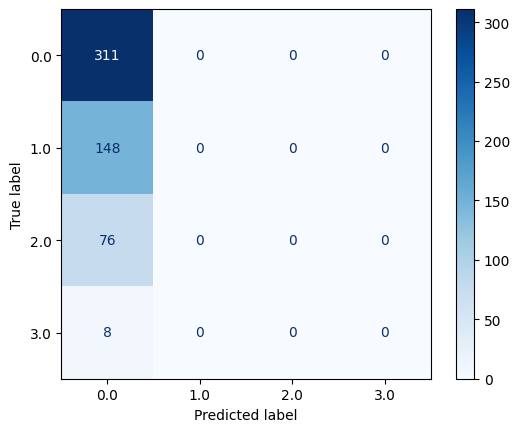

In [9]:
print("=== Model 0: Baseline ===")
run_baseline(X_train_final, y_train_final, X_test, y_test)

Si nota che le classi sono fortemente sbilanciate e, essendo un test medico, è essenziale minimizzare il numero di falsi negativi della categoria 3 (corrispondente a "severe").Infatti, un falso positivo è meno problematico, in quanto dopo la predizione con il modello, si può eseguire un test reale sulla persona.In caso di un falso negativo, invece, si scarta a priori l'ipotesi ed è più improbabile che venga effettuato un ulteriore test. 

Il test **non verrà mai usato** se non alla fine, per valutare le performance dei due modelli e confrontarle con la baseline

In [10]:
y_train_final = y_train_final.astype(int)
y_test = y_test.astype(int)
X_tr, X_val, y_tr, y_val = train_test_split(X_train_final, y_train_final, test_size=0.40, stratify=y_train_final, random_state=SEED)

X_tr_scaled, X_val_scaled, class_weights, scaler = prepare_X(X_tr, X_val, y_tr, y_val, SEED)
X_tr_scaled, X_val_scaled, imputer = impute_missing_values(X_tr, X_val, SEED, scaler)

C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Modello 1: XGBoost

Xgboost è un algoritmo di gradient boosting ottimizato che costruisce modelli ensemble di alberi decisionali in modo molto efficiente.
Nel nostro lavoro abbiamo seguito diversi passaggi per costruire e addestrare un modello di classificazione multiclasse basato su XGBoost. Per prima cosa abbiamo impostato il modello in modo da gestire più categorie, adattandolo quindi al contesto del nostro problema. Successivamente ci siamo occupati dello sbilanciamento delle classi: invece di lasciare che quelle più frequenti influenzassero troppo l’addestramento, abbiamo calcolato e applicato dei pesi proporzionati alla distribuzione.

A questo punto abbiamo introdotto Optuna, una libreria che permette di automatizzare l’ottimizzazione degli iperparametri. In questo modo il modello ha potuto essere testato con diverse configurazioni e noi abbiamo potuto individuare quella che massimizzava la metrica F1 ponderata sul validation set.

Infine, con gli iperparametri migliori selezionati, abbiamo addestrato il modello finale, ottenendo così una versione più robusta e meglio calibrata sulle nostre esigenze.

=== Model 1 ===
Best hyperparameters: {'max_depth': 6, 'learning_rate': 0.0244137576004884, 'min_child_weight': 14, 'subsample': 0.6714628317201746, 'colsample_bytree': 0.7212499562423165, 'gamma': 0.006903991150252932, 'reg_alpha': 2.2152146633597876, 'reg_lambda': 4.6726460198296795}
=== Validation Set ===
Accuracy: 0.6198738170347003
Weighted F1: 0.6545755845871841


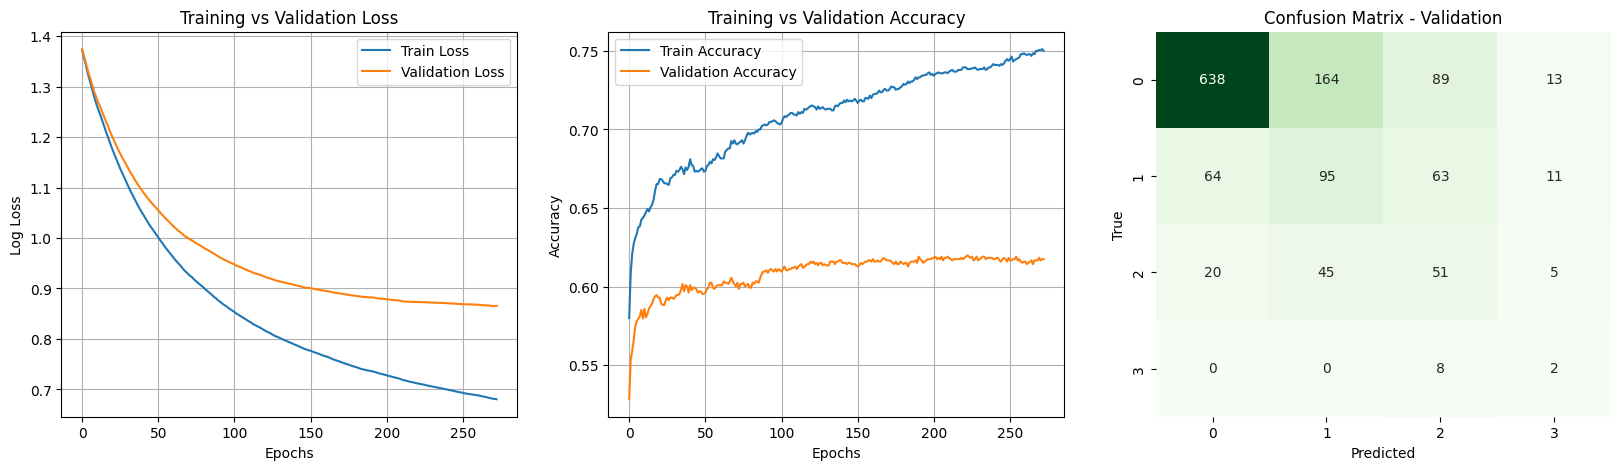

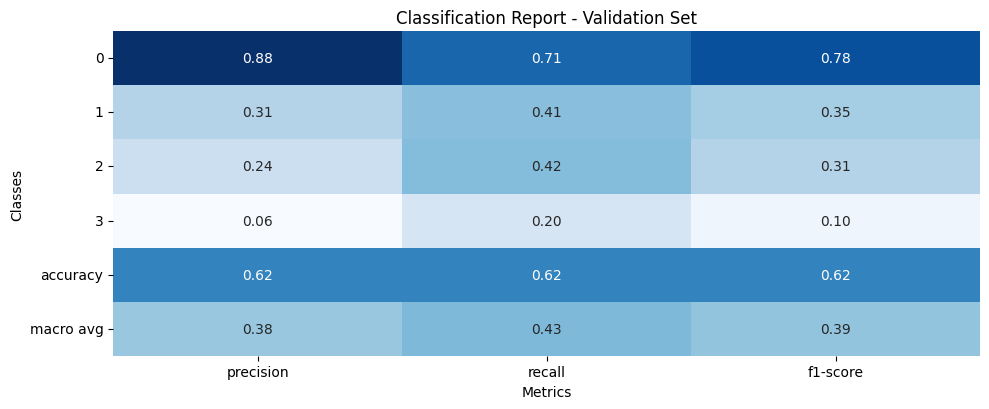

In [11]:
print("=== Model 1 ===")
model1, study = tune_and_train_xgboost(X_tr_scaled, y_tr, X_val_scaled, y_val, num_classes = 4)

## Modello 2: Rete Neurale, ensemble con RF

Siamo partiti dall’addestramento di una rete neurale, cercando di migliorarla variando diversi iperparametri, tra cui il numero di neuroni nei layer nascosti, le funzioni di attivazione, il dropout, la regolarizzazione L2 e il learning rate. Per affrontare il forte sbilanciamento del dataset, abbiamo anche provato a aumentare i pesi delle classi più rare. Successivamente, abbiamo testato altre strategie di miglioramento, come aggiungere neuroni o layer con regolarizzazione e utilizzare metriche alternative come MAE e MSE in virtù del rapporto ordinale tra le classi, senza però ottenere miglioramenti significativi.

Per la gestione dei valori mancanti, abbiamo utilizzato una prima Random Forest come imputer “intelligente”, stimando i NaN tenendo conto delle relazioni tra le variabili, anziché ricorrere a media, mediana o moda.

Infine, abbiamo adottato un approccio di classificazione a cascata: una seconda Random Forest viene allenata per predire la probabilità di appartenenza a due macrocategorie (“probabilmente sano - 0,1” vs “probabilmente problematico 2,3”), e la rete neurale utilizza questa nuova feature insieme alle altre per la classificazione finale. Questo approccio ha portato a un miglioramento significativo sulle prestazioni del modello sui dati di validazione.

=== Model 2: Neural Network ===
=== Confusion Matrix - TRAIN ===
[[1670   33]
 [   1  196]]

=== Confusion Matrix - VAL ===
[[1069   68]
 [  86   45]]

=== Classification Report - TRAIN ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1703
           1       0.86      0.99      0.92       197

    accuracy                           0.98      1900
   macro avg       0.93      0.99      0.96      1900
weighted avg       0.98      0.98      0.98      1900


=== Classification Report - VAL ===
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1137
           1       0.40      0.34      0.37       131

    accuracy                           0.88      1268
   macro avg       0.66      0.64      0.65      1268
weighted avg       0.87      0.88      0.87      1268

TRAIN Accuracy RF: 0.9821
VAL Accuracy RF: 0.8785


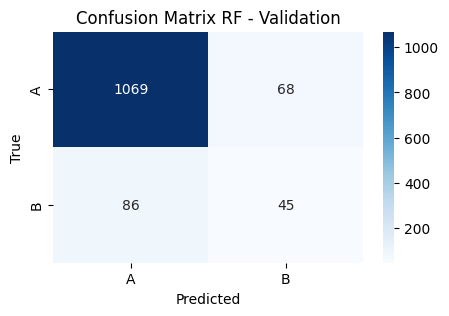

Shape train: (1900, 12)
Shape val: (1268, 12)


In [12]:
# 4. Modello 2
print("=== Model 2: Neural Network ===")

# primo step random forest
X_tr_aug, X_val_aug, n_features_aug, rf = rf_cascade(X_tr_scaled, y_tr, X_val_scaled, y_val, SEED)

In [13]:
# secondo step tuning automatico
X_tr_full, y_tr_full, final_model = tune_hyperparameters(X_tr_aug, y_tr, X_val_aug, y_val, n_features_aug, 4, class_weights)

Reloading Tuner from my_keras_tuner\dwm_tuning\tuner0.json

    ---  RICERCA COMPLETATA  ---

    I migliori iperparametri trovati sono:
    - Unità primo layer: 32
    - Unità secondo layer: 64
    - Funzione di attivazione: tanh
    - Tasso di Dropout: 0.50
    - Regolarizzazione L2: 0.0000
    - Learning Rate: 0.01
    

💪 Addestramento del modello finale con i parametri ottimali...


C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


# Test dei modelli

In [14]:
X_tr

,SDS-SDS_Total_T,SDS-SDS_Total_Raw,CGAS-CGAS_Score,Physical-Height,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-Season,Physical-HeartRate,PAQ_C-PAQ_C_Total,Physical-Systolic_BP,Basic_Demos-Age
977,45.0,31.0,85.0,45.00,47.2,2.0,3.0,87.0,NaN,115.0,5
425,60.0,43.0,NaN,54.00,82.8,0.0,3.0,75.0,1.33,105.0,8
800,67.0,48.0,80.0,66.00,137.0,NaN,0.0,81.0,2.91,115.0,13
2972,42.0,29.0,NaN,59.50,97.8,2.0,2.0,53.0,2.28,113.0,12
922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...
2234,62.0,44.0,71.0,49.25,50.0,0.0,1.0,80.0,NaN,124.0,6
1050,69.0,50.0,61.0,57.00,76.8,2.0,1.0,92.0,3.53,125.0,13
2728,47.0,33.0,60.0,59.00,71.6,2.0,0.0,77.0,1.87,113.0,12
756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [15]:
X_tr_full

array([[-1.24171252, -1.23781287,  0.62576443, ..., -0.09504218,
        -1.52089666,  0.01      ],
       [ 0.14505055,  0.16725202, -0.06366098, ..., -0.72874124,
        -0.66948132,  0.08463055],
       [ 0.79220665,  0.75269573,  0.46067214, ..., -0.09504218,
         0.74954424,  0.50384988],
       ...,
       [-1.42661426, -1.35490162,  0.46067214, ..., -0.40428732,
        -0.1018711 ,  0.02648173],
       [-1.14926165, -1.12072413,  0.29557985, ..., -0.91885096,
        -1.23709155,  0.01167387],
       [-1.42661426, -1.35490162,  0.04265846, ..., -0.2851519 ,
         0.18193401,  0.19358918]])

In [16]:
X_train_final

,SDS-SDS_Total_T,SDS-SDS_Total_Raw,CGAS-CGAS_Score,Physical-Height,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-Season,Physical-HeartRate,PAQ_C-PAQ_C_Total,Physical-Systolic_BP,Basic_Demos-Age
2536,45.0,31.0,NaN,66.00,151.8,3.0,3.0,73.0,NaN,120.0,16
1616,43.0,30.0,NaN,55.00,77.8,2.0,3.0,58.0,2.98,112.0,11
3350,72.0,52.0,60.0,48.88,69.8,1.0,1.0,76.0,NaN,113.0,6
2408,94.0,69.0,NaN,58.00,110.6,0.0,2.0,69.0,2.20,111.0,11
2802,NaN,NaN,40.0,62.50,107.2,2.0,NaN,NaN,NaN,NaN,17
...,...,...,...,...,...,...,...,...,...,...,...
3735,100.0,75.0,75.0,63.75,93.0,2.0,2.0,77.0,2.42,102.0,13
2919,NaN,NaN,NaN,43.50,42.8,0.0,NaN,72.0,NaN,105.0,6
3444,NaN,NaN,NaN,49.00,49.0,2.0,NaN,88.0,NaN,114.0,6
1238,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,17


In [17]:
X_val

,SDS-SDS_Total_T,SDS-SDS_Total_Raw,CGAS-CGAS_Score,Physical-Height,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-Season,Physical-HeartRate,PAQ_C-PAQ_C_Total,Physical-Systolic_BP,Basic_Demos-Age
2733,75.0,54.0,66.0,53.50,60.8,0.0,2.0,70.0,3.23,127.0,11
1487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
3748,80.0,58.0,55.0,49.13,67.2,2.0,0.0,109.0,NaN,141.0,6
1428,59.0,42.0,70.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,7
536,NaN,NaN,NaN,65.00,120.6,3.0,NaN,65.0,2.00,111.0,14
...,...,...,...,...,...,...,...,...,...,...,...
2242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2218,58.0,41.0,80.0,50.50,0.0,0.0,3.0,79.0,NaN,123.0,6
111,43.0,30.0,80.0,NaN,NaN,0.0,0.0,NaN,2.00,NaN,10
2186,46.0,32.0,75.0,50.00,61.8,0.0,1.0,88.0,NaN,102.0,6


In [18]:
y_tr

977     0
425     0
800     0
2972    1
922     0
       ..
2234    0
1050    2
2728    1
756     0
422     0
Name: sii, Length: 1900, dtype: int64

In [19]:
y_tr_full

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
y_train_final

2536    1
1616    0
3350    2
2408    0
2802    0
       ..
3735    0
2919    0
3444    0
1238    0
3507    0
Name: sii, Length: 3168, dtype: int64

In [21]:
y_val

2733    0
1487    0
3748    0
1428    0
536     0
       ..
2242    0
2218    1
111     0
2186    0
1616    0
Name: sii, Length: 1268, dtype: int64

In [22]:
X_test

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
149,Winter,12,0,Summer,60.0,Winter,15.781633,56.00,70.4,NaN,...,1.0,1.0,1.0,1.0,29.0,Spring,39.0,55.0,Winter,0.0
1025,Spring,9,0,Fall,67.0,Summer,13.620027,52.50,53.4,NaN,...,0.0,0.0,0.0,0.0,5.0,Summer,26.0,38.0,Spring,0.0
1846,Winter,17,1,Summer,83.0,Spring,21.318601,67.80,139.4,NaN,...,0.0,0.0,0.0,0.0,4.0,Winter,36.0,51.0,Winter,2.0
325,Spring,12,0,NaN,NaN,Summer,14.861442,59.88,75.8,NaN,...,2.0,1.0,1.0,1.0,28.0,Spring,50.0,69.0,Spring,0.0
408,Spring,10,0,Spring,74.0,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,1.0,2.0,48.0,Summer,36.0,51.0,Spring,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,Summer,8,0,Spring,67.0,Summer,13.468555,49.00,46.0,20.0,...,0.0,3.0,0.0,1.0,28.0,Winter,35.0,50.0,Summer,0.0
1226,Spring,7,1,Summer,70.0,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,1.0,1.0,21.0,Summer,39.0,55.0,Spring,2.0
736,Fall,8,0,Spring,60.0,Winter,24.726379,53.00,98.8,NaN,...,2.0,1.0,1.0,0.0,26.0,Winter,34.0,49.0,Fall,3.0
3292,Fall,12,1,Winter,59.0,Winter,20.388908,62.75,114.2,NaN,...,3.0,2.0,0.0,0.0,43.0,Fall,30.0,43.0,Fall,2.0


In [23]:
y_test

149     0
1025    0
1846    0
325     0
408     1
       ..
3548    0
1226    0
736     0
3292    1
927     0
Name: sii, Length: 543, dtype: int64

In [24]:
X_test11 = X_test.copy()
X_test11

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
149,Winter,12,0,Summer,60.0,Winter,15.781633,56.00,70.4,NaN,...,1.0,1.0,1.0,1.0,29.0,Spring,39.0,55.0,Winter,0.0
1025,Spring,9,0,Fall,67.0,Summer,13.620027,52.50,53.4,NaN,...,0.0,0.0,0.0,0.0,5.0,Summer,26.0,38.0,Spring,0.0
1846,Winter,17,1,Summer,83.0,Spring,21.318601,67.80,139.4,NaN,...,0.0,0.0,0.0,0.0,4.0,Winter,36.0,51.0,Winter,2.0
325,Spring,12,0,NaN,NaN,Summer,14.861442,59.88,75.8,NaN,...,2.0,1.0,1.0,1.0,28.0,Spring,50.0,69.0,Spring,0.0
408,Spring,10,0,Spring,74.0,NaN,NaN,NaN,NaN,NaN,...,4.0,2.0,1.0,2.0,48.0,Summer,36.0,51.0,Spring,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,Summer,8,0,Spring,67.0,Summer,13.468555,49.00,46.0,20.0,...,0.0,3.0,0.0,1.0,28.0,Winter,35.0,50.0,Summer,0.0
1226,Spring,7,1,Summer,70.0,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,1.0,1.0,21.0,Summer,39.0,55.0,Spring,2.0
736,Fall,8,0,Spring,60.0,Winter,24.726379,53.00,98.8,NaN,...,2.0,1.0,1.0,0.0,26.0,Winter,34.0,49.0,Fall,3.0
3292,Fall,12,1,Winter,59.0,Winter,20.388908,62.75,114.2,NaN,...,3.0,2.0,0.0,0.0,43.0,Fall,30.0,43.0,Fall,2.0


In [25]:
X_test11 = X_test11[features_list]
X_test11

,SDS-SDS_Total_T,SDS-SDS_Total_Raw,CGAS-CGAS_Score,Physical-Height,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-Season,Physical-HeartRate,PAQ_C-PAQ_C_Total,Physical-Systolic_BP,Basic_Demos-Age
149,55.0,39.0,60.0,56.00,70.4,0.0,Spring,59.0,NaN,112.0,12
1025,38.0,26.0,67.0,52.50,53.4,0.0,Summer,96.0,2.120,116.0,9
1846,51.0,36.0,83.0,67.80,139.4,2.0,Winter,57.0,NaN,149.0,17
325,69.0,50.0,NaN,59.88,75.8,0.0,Spring,74.0,1.050,116.0,12
408,51.0,36.0,74.0,NaN,NaN,3.0,Summer,NaN,2.220,NaN,10
...,...,...,...,...,...,...,...,...,...,...,...
3548,50.0,35.0,67.0,49.00,46.0,0.0,Winter,52.0,4.019,94.0,8
1226,55.0,39.0,70.0,NaN,NaN,2.0,Summer,NaN,NaN,NaN,7
736,49.0,34.0,60.0,53.00,98.8,3.0,Winter,84.0,1.830,115.0,8
3292,43.0,30.0,59.0,62.75,114.2,2.0,Fall,80.0,2.420,105.0,12


In [26]:
X_tr_scaled

array([[-1.24171252, -1.23781287,  0.62576443, ...,  0.21413654,
        -0.09504218, -1.52089666],
       [ 0.14505055,  0.16725202, -0.06366098, ..., -2.13031967,
        -0.72874124, -0.66948132],
       [ 0.79220665,  0.75269573,  0.46067214, ...,  0.58579765,
        -0.09504218,  0.74954424],
       ...,
       [-1.05681077, -1.00363539, -0.19969702, ..., -1.20202641,
        -0.221782  ,  0.46573913],
       [ 0.05259968,  0.05016328,  0.02218701, ...,  0.77042487,
        -0.0836356 , -0.95328643],
       [ 0.05259968,  0.05016328,  0.06973359, ...,  0.02651815,
        -0.66030174,  0.46573913]])

In [27]:
X_val_scaled

array([[ 1.53181362e+00,  1.45522818e+00, -1.58627624e-03, ...,
         1.13589736e+00,  6.65396682e-01,  1.81934014e-01],
       [ 5.25996798e-02,  5.01632819e-02, -2.14225146e-01, ...,
        -3.51744160e-01, -1.32822055e+00, -1.23709155e+00],
       [ 1.99406797e+00,  1.92358315e+00, -3.64789315e-01, ...,
        -1.69099629e+00,  1.55257536e+00, -1.23709155e+00],
       ...,
       [-1.42661426e+00, -1.35490162e+00,  4.60672136e-01, ...,
        -9.78548398e-01, -4.04287323e-01, -1.01871098e-01],
       [-1.14926165e+00, -1.12072413e+00,  2.95579846e-01, ...,
        -9.29222459e-02, -9.18850957e-01, -1.23709155e+00],
       [-1.42661426e+00, -1.35490162e+00,  4.26584575e-02, ...,
         7.06131965e-01, -2.85151901e-01,  1.81934014e-01]])

c:\Users\Dav\Uni_Lavoro\data-web-mining-project\src\data_cleaning_module.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].map(season_map)


=== XGBoost - Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.7671    0.5402    0.6340       311
           1     0.3133    0.3514    0.3312       148
           2     0.2500    0.4737    0.3273        76
           3     0.0714    0.1250    0.0909         8

    accuracy                         0.4733       543
   macro avg     0.3505    0.3726    0.3458       543
weighted avg     0.5608    0.4733    0.5005       543



C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


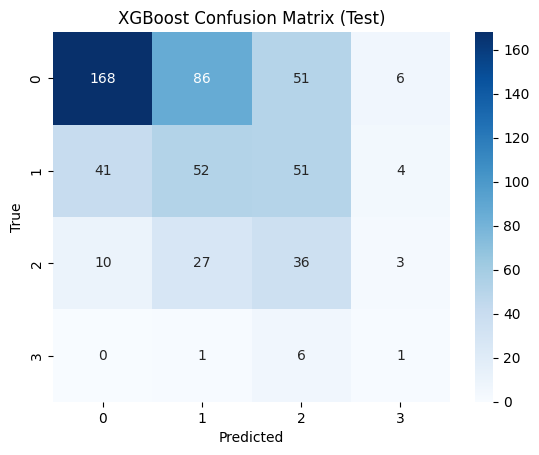

In [28]:
test_xgboost(model1, X_test11, y_test, scaler, imputer)

c:\Users\Dav\Uni_Lavoro\data-web-mining-project\src\data_cleaning_module.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].map(season_map)
C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Dav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classifica

=== ANN Ensemble - Classification Report (Test) ===
              precision    recall  f1-score   support

           0     0.5727    1.0000    0.7283       311
           1     0.0000    0.0000    0.0000       148
           2     0.0000    0.0000    0.0000        76
           3     0.0000    0.0000    0.0000         8

    accuracy                         0.5727       543
   macro avg     0.1432    0.2500    0.1821       543
weighted avg     0.3280    0.5727    0.4172       543



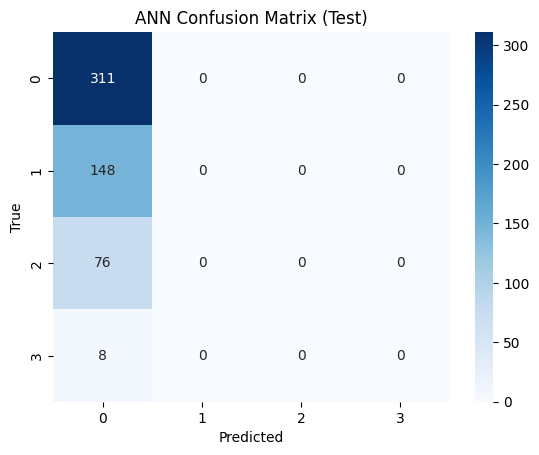

In [29]:

test_ann_pipeline(X_test11, y_test, final_model, rf)